<img src="https://bit.ly/2VnXWr2" width="100" align="left">

# Final project: NLP to predict Myers-Briggs Personality Type

## Introduction

In order to learn more on NLP while applaying its methods to psychological variables I have been working on this dataset from Kaggle, [(MBTI) Myers-Briggs Personality Type Dataset](https://www.kaggle.com/datasnaek/mbti-type), that holds data collected through the [PersonalityCafe forum](http://personalitycafe.com/forum/), as it provides a large selection of people and their MBTI personality type, as well as what they have written. 

Moreover, I have been spreading a Google Form so as to obtain similar data on my own.

### Objectives

I mainly wanted to create a **classification model using text data features and meta-features from each user comments, messages and posts to predict their personalities**. Once the model is trained, **I plan to test it in a different dataset I have generated** by surveying me network contacts and their contacts.

## Imports

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Visualization for text
from PIL import Image
from os import path
import os
import random
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import spacy
import string
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from collections import Counter

# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Ignore noise warning
import warnings
warnings.filterwarnings('ignore')

# Work with pickles
import pickle

# Fix imbalance
from imblearn.under_sampling import InstanceHardnessThreshold

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

pd.set_option("display.max_column", None)

Using TensorFlow backend.


## 1. Exploratory Data Analysis

### Context


The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

- Introversion (I) – Extroversion (E)
- Intuition (N) – Sensing (S)
- Thinking (T) – Feeling (F)
* Judging (J) – Perceiving (P)

[(More can be learned about what these mean here)](http://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/home.htm)

So for example, someone who prefers introversion, intuition, thinking and judging would be labelled an INTJ in the MBTI system, and there are lots of personality based components that would model or describe this person’s preferences or behaviour based on the label.

It is one of, if not the, the most popular personality test in the world. It is used in businesses, online, for fun, for research and lots more. A simple google search reveals all of the different ways the test has been used over time. It’s safe to say that this test is still very relevant in the world in terms of its use.

From scientific or psychological perspective it is based on the work done on [cognitive functions](http://www.cognitiveprocesses.com/Cognitive-Functions/) by Carl Jung i.e. Jungian Typology. This was a model of 8 distinct functions, thought processes or ways of thinking that were suggested to be present in the mind. Later this work was transformed into several different personality systems to make it more accessible, the most popular of which is of course the MBTI.

I need to add that for the dataset I generated I haven't used the original MBTI test, but a test based on it, [16Personalities](https://www.16personalities.com/), which adds a new axis that I omitted for validity reasons.

**Content**

This dataset contains over 8600 rows of data, on each row is a person’s:

- Type (This persons 4 letter MBTI code/type)
- A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

### EDA

#### Read dataset and check head

In [2]:
mbti_df = pd.read_csv("../your-project/data/mbti_1.csv")
mbti_df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


#### Check shape

In [3]:
mbti_df.shape

(8675, 2)

#### Check dtypes and columns

In [4]:
mbti_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


#### Check nulls and duplicates

In [5]:
mbti_df.isna().sum()

type     0
posts    0
dtype: int64

In [6]:
mbti_df.duplicated().sum()

0

#### Check unique values

In [7]:
mbti_df.nunique()

type       16
posts    8675
dtype: int64

#### Check target variable distribution

In [8]:
mbti_df.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

#### Target variable distribution visualization

I will use countplots to visualize most frequent types. *I will also try to visualize the same based on the associted pieces of text's lenghts.

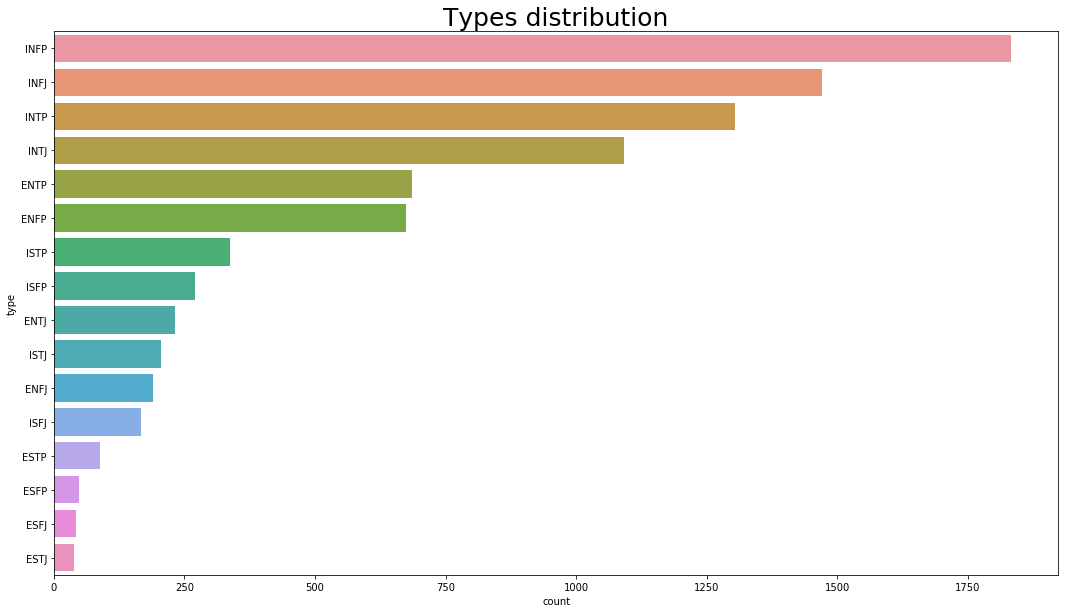

In [9]:
plt.figure(figsize=(18,10))
sns.countplot(y="type",data=mbti_df, order=mbti_df.type.value_counts().index)
sns.set_context("talk")
plt.title("Types distribution", fontsize=25)
plt.savefig("images/output_images/mbti_count.png")
plt.show()

In [10]:
mbti_df.describe().T

,count,unique,top,freq
type,8675,16,INFP,1832
posts,8675,8675,1. Would you want to live forever? Why/why not...,1


I will use wordclouds to visualize most common words in posts column.

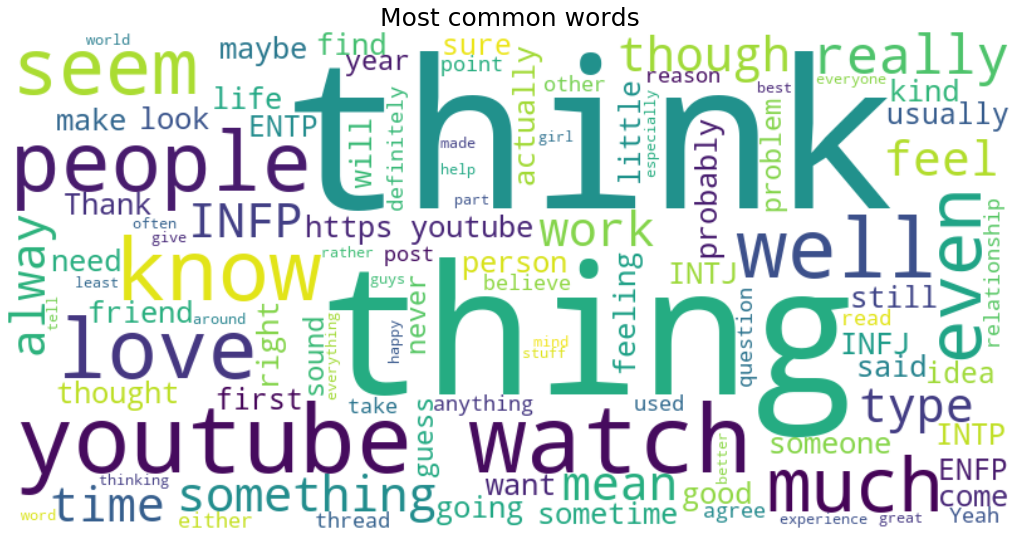

In [11]:
# Read the whole text.
text = " ".join(mbti_df["posts"])

# Generate a word cloud image
stopwords = STOPWORDS
wordcloud = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords, max_words=100, repeat=False, min_word_length=4).generate(text)

# Display the generated image:
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
sns.set_context("talk")
plt.title("Most common words", fontsize=25)
plt.savefig("images/output_images/mbti_cloud.png")
plt.show()

#### Comments
It seems there is terms that are more frequent than others but we still can't establish any sort of relationship between those terms' frequencies and our target variable. ***Buscar distribución del MBTI en función de estudios***

### Categorical columns: Text and lots of uniques
In order to better appreciate if it may be a relationship between text and personality types, we will tokenize the text to form a Bag of Words.

#### BoW

In [15]:
mbti_text = mbti_df[["type","posts"]].copy()

In [18]:
mbti_text = mbti_text.fillna("")
text_columns = mbti_text[["type"]]
text_columns["text"] = mbti_text.iloc[:,1:].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

In [19]:
def clean_urls(column):
    """
    This function takes a string and returns a string 
    with its urls removed and all the words in lowercase.
    """
    return column.apply(lambda x: x.lower()).apply(lambda x: re.sub("http[s]?://\S+", "", x))

text_columns["text"] = clean_urls(text_columns["text"])

<img src="https://www.nicepng.com/png/detail/148-1486992_discover-the-most-powerful-ways-to-automate-your.png" width="1000"> 

In [20]:
raise SystemExit("Stop right there! Run cells one by one till the next heading.")

SystemExit: Stop right there! Run cells one by one till the next heading.

In [21]:
nlp = spacy.load("en_core_web_sm", disable = ["ner", "parser"]) 
nlp.max_length = 33000000

In [22]:
def tokenize(string):
    '''
    This function takes a sentence and returns the list of all lemma
    '''
    doc = nlp(string)
    l_token = [token.text for token in doc if not token.is_punct 
               | token.is_space | token.is_stop | token.is_digit & token.is_oov]
    return ' '.join(l_token)


text_columns["text"] = text_columns["text"].apply(lambda row: tokenize(row))

In [23]:
pd_token = pd.DataFrame(text_columns, columns=['type', 'text'])
pd_token.head()

,type,text
0,INFJ,intj moments sportscenter plays pranks|||what ...
1,ENTP,finding lack posts alarming.|||sex boring posi...
2,INTP,good course know blessing curse.|||does absolu...
3,INTJ,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,fired.|||that silly misconception approaching ...


In [24]:
pd_token.to_pickle("data/output_pickles/token.pkl")

#### Visualization

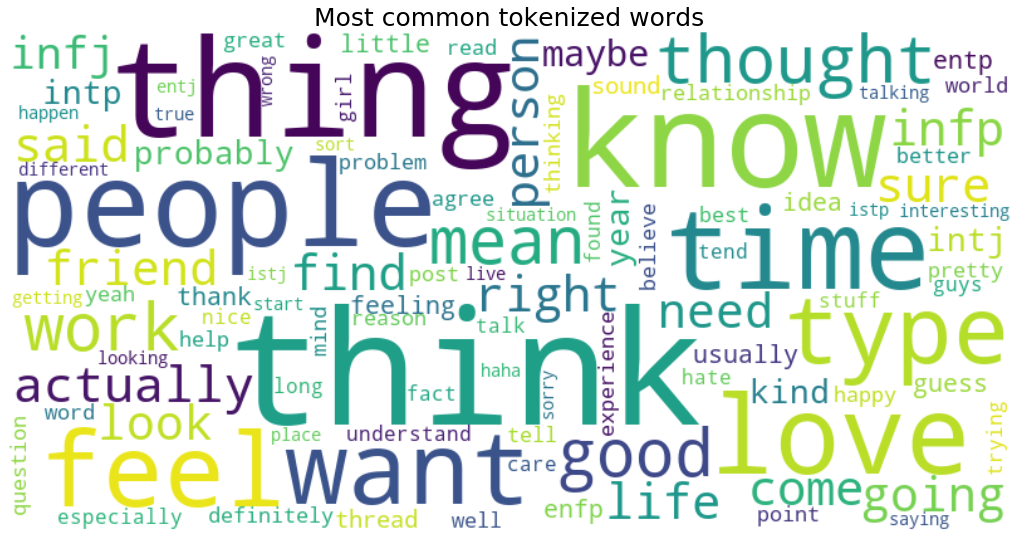

In [25]:
# Read the whole text.
text = " ".join(pd_token["text"])

# Generate a word cloud image
stopwords = STOPWORDS
wordcloud = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords, max_words=100, repeat=False, min_word_length=4).generate(text)

# Display the generated image:
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
sns.set_context("talk")
plt.title("Most common tokenized words", fontsize=25)
plt.savefig("images/output_images/mbti_token_cloud.png")
plt.show()

#### Comments

After tokenizing we can se that there's words or short expressions which are more common than others in "text" columns but there's still too much information and it is too raw as to get interesting insights from it.